<a href="https://colab.research.google.com/github/eunShim/BigDataCapstone/blob/main/bigdatacapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3652682442.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54400 (\N{HANGUL SYLLABLE PUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

총 시도 횟수와 평균 풀이 시간 상관계수: 0.378


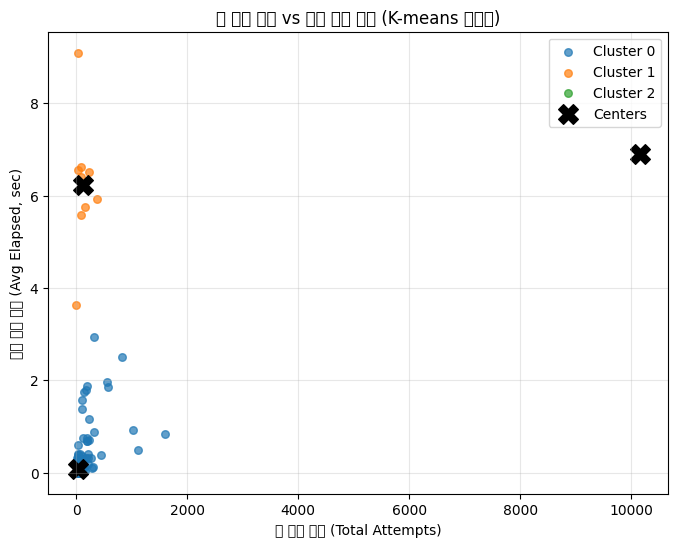

In [43]:
import zipfile
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# =======================================
# 1. ZIP에서 사용자 샘플링 (예: 500명)
# =======================================
zip_path = "/content/EdNet-KT3.zip"

with zipfile.ZipFile(zip_path, 'r') as z:
    user_files = [f for f in z.namelist() if f.startswith("KT3/") and f.endswith(".csv")]
    k = min(500, len(user_files))
    sample_files = random.sample(user_files, k)

    dfs = []
    for f in sample_files:
        with z.open(f) as fp:
            df = pd.read_csv(fp, low_memory=False)
            df["source_file"] = f.split("/")[-1].replace(".csv", "")
            dfs.append(df)

df_sample = pd.concat(dfs, ignore_index=True)

# =======================================
# 2. 사용자별 특징 추출
# =======================================
# enter → submit 시간차로 평균 풀이시간 계산
def compute_avg_elapsed(user_df):
    # enter/submit 이벤트만 추출
    enter_times = user_df.loc[user_df["action_type"] == "enter", "timestamp"].reset_index(drop=True)
    submit_times = user_df.loc[user_df["action_type"] == "submit", "timestamp"].reset_index(drop=True)
    if len(enter_times) == 0 or len(submit_times) == 0:
        return np.nan
    n = min(len(enter_times), len(submit_times))
    elapsed = pd.to_datetime(submit_times[:n]) - pd.to_datetime(enter_times[:n])
    elapsed = elapsed.dt.total_seconds()
    return elapsed.mean()

user_stats = (
    df_sample.groupby("source_file")
    .apply(lambda x: pd.Series({
        "total_attempts": (x["action_type"] == "submit").sum(),
        "avg_elapsed": compute_avg_elapsed(x)
    }))
    .reset_index()
)

# 결측치 제거
user_stats = user_stats.dropna()

# =======================================
# 3. K-means 군집화
# =======================================
X = user_stats[["total_attempts", "avg_elapsed"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
user_stats["cluster"] = kmeans.fit_predict(X_scaled)

# =======================================
# 4. 상관관계 계산
# =======================================
corr = user_stats[["total_attempts", "avg_elapsed"]].corr().iloc[0,1]
print(f"총 시도 횟수와 평균 풀이 시간 상관계수: {corr:.3f}")

# =======================================
# 5. 시각화
# =======================================
plt.figure(figsize=(8,6))
for cluster_id in sorted(user_stats["cluster"].unique()):
    cluster_data = user_stats[user_stats["cluster"] == cluster_id]
    plt.scatter(cluster_data["total_attempts"], cluster_data["avg_elapsed"],
                s=30, alpha=0.7, label=f"Cluster {cluster_id}")

# 클러스터 중심 표시
centers = kmeans.cluster_centers_
centers_orig = scaler.inverse_transform(centers)
plt.scatter(centers_orig[:,0], centers_orig[:,1], c="black", s=200, marker="X", label="Centers")

plt.xlabel("총 시도 횟수 (Total Attempts)")
plt.ylabel("평균 풀이 시간 (Avg Elapsed, sec)")
plt.title("총 시도 횟수 vs 평균 풀이 시간 (K-means 군집화)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
